## Identifiable VAE

> https://arxiv.org/pdf/1907.04809.pdf

$E_D[logp_\theta(x|u)] ≥ L(θ,φ)=$
$E_D[E_{q_\phi(z|x,u)}[logp_\theta(x,z|u)−logq_\phi(z|x,u)]] = $
$E_D[E_{q_\phi(z|x,u)}[logp_\theta(x|z) + logp_\theta(z|u) −logq_\phi(z|x,u)]]$

Rewrite result in terms of output variable

$E_D[logp_\theta(x|u)] ≥ L(θ,φ)$

In [528]:
import numpy as np
import torch.nn as nn

In [510]:
import torch
import torch.nn as nn
import numpy as np

class Q(nn.Module):
    
    def __init__(self,n_latent=10, n_hidden=5):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(3, n_hidden), 
                                 nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden), 
                                 nn.LeakyReLU(), 
                      #           nn.Linear(n_hidden, n_hidden), 
                       #          nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.LeakyReLU(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.LeakyReLU())
        
        self.mu = nn.Linear(n_hidden, n_latent)
        self.logv = nn.Linear(n_hidden, n_latent)
        
    def forward(self, X, U):
        #print(X, U)
        XU = torch.cat([X, U], dim=1)
        F = self.net(XU)
        
        mu, logv = self.mu(F), self.logv(F)
        e = torch.distributions.Normal(0, 1).sample(mu.shape).to(mu.device)
        
        if self.training:
            v = logv.mul(0.5).exp_()
            Z = (e * v) + mu
        else:
            Z = mu
        return Z, mu, logv
    
    
class P_z(nn.Module):

    def __init__(self,n_latent=10, n_hidden=5):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, n_hidden), 
                                 nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden), 
                                 nn.LeakyReLU(), 
                        #         nn.Linear(n_hidden, n_hidden), 
                        #         nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.LeakyReLU(),
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.LeakyReLU())

        self.mu = nn.Linear(n_hidden, n_latent)
        self.logv = nn.Linear(n_hidden, n_latent)

    def forward(self, U):
        F = self.net(U)
        mu, logv = self.mu(F), self.logv(F) 
        return mu, logv
    
    
class P_x(nn.Module):

    def __init__(self,n_latent=2, n_hidden=5):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_latent, n_hidden), 
                                 nn.LeakyReLU(), 
                         #        nn.Linear(n_hidden, n_hidden), 
                          #       nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden), 
                                 nn.LeakyReLU(), 
                                 nn.Linear(n_hidden, n_hidden),
                                 nn.LeakyReLU(),
                                 nn.Linear(n_hidden, 2))

    def forward(self, Z):
        Y = self.net(Z)
        return Y
      
    
class Model(nn.Module) :
      
    def __init__(self,n_latent=2, n_hidden=5):
        super().__init__()

        self.px = P_x(n_latent, n_hidden)
        self.pz = P_z(n_latent, n_hidden)
        self.q = Q(n_latent, n_hidden)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight) # torch.nn.init.normal_(m.weight,0,1)
            m.bias.data.fill_(0.0001)

    
    def predict(self, U, n_samples=1):
        prior_mu, prior_logv = self.pz(U)
        Y = []
        for s in range(n_samples):
            e = torch.distributions.Normal(0, 1).sample(prior_mu.shape).to(prior_mu.device)
            v = prior_logv.mul(0.5).exp_()
            Z = (e * v) + prior_mu
            Y.append(self.px(Z).detach())
        return torch.stack(Y)
            
    def forward(self, X, U):
        Z, mu, logv = self.q(X, U) 
        prior_mu, prior_logv = self.pz(U)
        X_pred = self.px(Z)       
        return X_pred, Z, mu, logv, prior_mu, prior_logv
       
class ELBO(nn.Module):
    
    @staticmethod
    def _px(trgt, pred, sigma=0.001):
        return torch.distributions.Normal(trgt.flatten(), sigma*torch.ones_like(trgt.flatten())).log_prob(pred.flatten()).view(pred.shape).sum(1)
   
    @staticmethod
    def _pz(z, mu, logv):
        v = logv.mul(0.5).exp_()
        return torch.distributions.Normal(mu.flatten(), v.flatten()).log_prob(z.flatten()).view(z.shape).sum(1)
    
    @staticmethod
    def _qz(z, mu, logv):
        v = logv.mul(0.5).exp_()
        return torch.distributions.Normal(mu.flatten(), v.flatten()).log_prob(z.flatten()).view(z.shape).sum(1)
    
    def __repr__(self):
        return "ELBO"
     
    def forward(self, output, X):
        X_pred, Z, mu, logv, prior_mu, prior_logv = output
        elb = ELBO._px(X, X_pred) + ELBO._pz(Z, prior_mu, prior_logv) - ELBO._qz(Z, mu, logv)                
        return elb.mean()


In [506]:
class MIXING_MLP(nn.Module):
    
    def __init__(self,n_latent=10):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, n_latent) , nn.LeakyReLU(), nn.Linear(n_latent, n_latent), nn.LeakyReLU(), nn.Linear(n_latent, 2))
        
    def forward(self, X):
        return self.net(X)

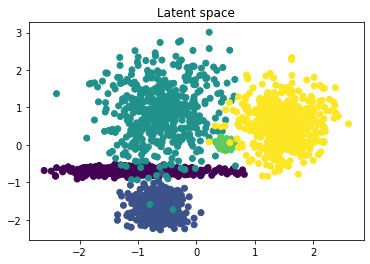

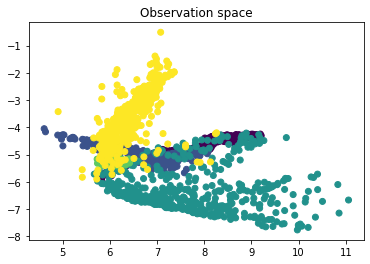

In [525]:
np.random.seed(91)
torch.random.manual_seed(105)

n = 512
m = 2
T = 5
sigma = 0.001

X = []
U = []

for i, (loc, scale) in enumerate(zip(np.random.uniform(-0.5, 0.5, (T, 2)), np.random.uniform(.001, .2, (T, 2)))):
    x, y = np.random.normal(loc[0], scale[0], (n,)), np.random.normal(loc[1], scale[1], (n,))
    X.append((x, y))  
    U.append( [i] * n)

U = np.asarray(U).reshape(n * T, 1).astype(np.float32)
    
Z = np.asarray(X).transpose(0, 2, 1).reshape(n * T, m)
Z = Z / Z.std(0)

plt.scatter(Z[:, 0], Z[:, 1] , c=U)
plt.title("Latent space")
plt.show()

mixing = MIXING_MLP(25)
X = mixing(torch.Tensor(Z) ).detach()
X = X + np.random.normal(0, sigma, X.shape).astype(np.float32)
X = X / X.std(0)

plt.scatter(X[:, 0], X[:, 1] , c=U)
plt.title("Observation space")
plt.show()

In [526]:
device = "cuda"

model = Model(n_latent=2, n_hidden=30).to(device)
criterion = ELBO().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

X_, U_ = X.to(device), torch.from_numpy(U).to(device)

ds = torch.utils.data.TensorDataset(X_ , U_)
dl = torch.utils.data.DataLoader(ds, 64 , shuffle=True)

In [527]:
for ep in range(1000):
    
    for x, u in dl:
    
        optim.zero_grad()
        output = model(x, u)
        elbo = criterion(output, x)
        (-elbo).backward()
        optim.step()
        
    if ep % 50 == 0:

        print("Epoch", ep, f"{elbo.detach().item():.3f}")

Epoch 0 -3347492.500
Epoch 50 -443.245
Epoch 100 -935.202
Epoch 150 -760.184
Epoch 200 -124.884
Epoch 250 -420.856
Epoch 300 -247.770
Epoch 350 -58.753
Epoch 400 -18.354
Epoch 450 -49.109
Epoch 500 -8.860
Epoch 550 -6.662
Epoch 600 -172.152
Epoch 650 -37.683
Epoch 700 -11.646
Epoch 750 -190.143
Epoch 800 -25.280
Epoch 850 -204.209
Epoch 900 -100.294
Epoch 950 -916.637


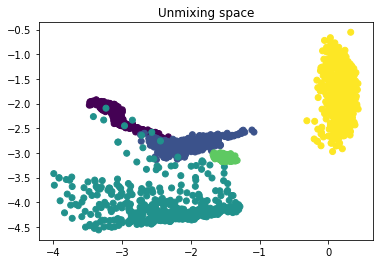

In [521]:
Z_unmix =  model(X_, U_)[2].detach().cpu().numpy() # X_pred, Z, mu, logv, prior_mu, prior_logv

plt.scatter(Z_unmix[:, 0], Z_unmix[:, 1] , c=U)
plt.title("Unmixing space")
plt.show()

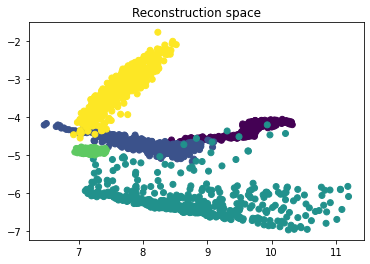

In [522]:
X_pred =  model(X_, U_)[0].detach().cpu().numpy() # X_pred, Z, mu, logv, prior_mu, prior_logv

plt.scatter(X_pred[:, 0], X_pred[:, 1] , c=U)
plt.title("Reconstruction space")
plt.show()